In [ ]:
#install
import pybamm
import pybammeis
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [39]:
#install
import pybamm
import pybammeis
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Set seed 
np.random.seed(0)

# Define the DFN model or PMe model with degradation mechanisms(SEI growth & lithium plating and particle cracking)

model = pybamm.lithium_ion.DFN(
    {
      "thermal": "isothermal",
      "SEI": "solvent-diffusion limited",
       "SEI porosity change": "true",
       "lithium plating": "partially reversible",
       "lithium plating porosity change": "true",  # alias for "SEI porosity change"
       "particle mechanics": ("swelling and cracking","swelling only"),
       "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versionsg
        
    }
)

# Load parameter values (OKane2022)
param = pybamm.ParameterValues("OKane2022")
param.update({
    "Initial temperature [K]": 278.15, #change the temperature 
    "SEI growth activation energy [J.mol-1]": 37000.0,
    #"Negative electrode initial crack length [m]":2e-99,
    #"Positive electrode initial crack length [m]":2e-8,
    #"Negative electrode initial crack width [m]":1.5e-99,
    #"Positive electrode initial crack width [m]":1.5e-8,
    "Ambient temperature [K]": 278.15,},)

# Discretization points
var_pts = {
    "x_n": 5,
    "x_s": 5,
    "x_p": 5,
    "r_n": 30,
    "r_p": 30,
}


safe_solver = pybamm.IDAKLUSolver() #for fast simulation
# Number of cycles
cycle_number = 10  # for  aging


aged_model = model
all_solutions = [] 

# Run 1 full charge/discharge/hold cycle at a time
for cycle in range(1, cycle_number + 1):
    print(f"\n Running cycle {cycle}...")

    # Define a single full cycle
    exp = pybamm.Experiment([
        (
            "Discharge at 1C until 2.5 V",
            "Charge at 5 A until 4.2 V",
            "Hold at 4.2 V until C/100",
            "Rest for 30 minutes",
        )
    ],period="1 minutes",) #change this for good accuracy

    # Run the cycle using the aged model 
    sim = pybamm.Simulation(
        aged_model,
        parameter_values=param,
        experiment=exp,
        solver=safe_solver,
        var_pts=var_pts,
    )
    sol = sim.solve(calc_esoh=True,initial_soc=1)
    all_solutions.append(sol)
    # Calculate the capacity and SOH
   
    # Update the model with the aged state
    aged_model = model.set_initial_conditions_from(sol)
    



 Running cycle 1...

 Running cycle 2...

 Running cycle 3...

 Running cycle 4...

 Running cycle 5...

 Running cycle 6...

 Running cycle 7...

 Running cycle 8...

 Running cycle 9...

 Running cycle 10...


In [50]:
# degradation metrics

Q_initial = None
throughput_capacities = []
discharge_capacities = []
loss_lithium_ah = []
SOH_values = []

Q_SEI = []
Q_SEI_cr = []
Q_plating = []
Q_LLI = []
Qt = []
charge_times = []
discharges_times = []
rest_times = []
hold_times = []
total_times = []
Voltage = []
current = []
# ------------------------------
# Extract degradation data

for i in range(len(all_solutions)):
    
        discharge = all_solutions[i].cycles[0].steps[0]
        charge    = all_solutions[i].cycles[0].steps[1]
        hold      = all_solutions[i].cycles[0].steps[2]
        rest = all_solutions[i].cycles[0].steps[3]

         # Individual step durations
        t_discharge = discharge["Time [h]"].entries[-1]
        t_charge = charge["Time [h]"].entries[-1]
        t_hold = charge["Time [h]"].entries[-1]
        t_rest = rest["Time [h]"].entries[-1]
        Voltage_cycles=all_solutions[i]["Voltage [V]"].entries
        # Discharge capacity and throughput
        Q_discharge = discharge["Discharge capacity [A.h]"].entries[-1]
        Q_throughput = discharge["Throughput capacity [A.h]"].entries[-1]
        Voltage.append(Voltage_cycles)
        #times
        charge_times.append(t_charge)
        discharges_times.append(t_discharge)
        rest_times.append(t_rest)
        hold_times.append(t_hold)
        total_times.append(t_discharge + t_charge + t_hold + t_rest)
         
        if Q_initial is None:
            Q_initial =  Q_discharge # 
            

        throughput_capacities.append(Q_throughput)
        discharge_capacities.append(Q_discharge)
        SOH_values.append(Q_discharge / Q_initial)
    

        # Lithium inventory loss (mol → Ah)
        lli_mol = hold["Total lithium lost [mol]"].entries[-1]
        lli_ah = lli_mol * 96485.3 / 3600
        loss_lithium_ah.append(lli_ah)
        Q_LLI.append(lli_ah)

        # Degradation contributions
        Qt.append(hold["Throughput capacity [A.h]"].entries[-1])
        Q_SEI.append(hold["Loss of capacity to negative SEI [A.h]"].entries[-1])
        Q_SEI_cr.append(all_solutions[i]["Loss of capacity to negative SEI on cracks [A.h]"].entries[-1])
        Q_plating.append(hold["Loss of capacity to negative lithium plating [A.h]"].entries[-1])

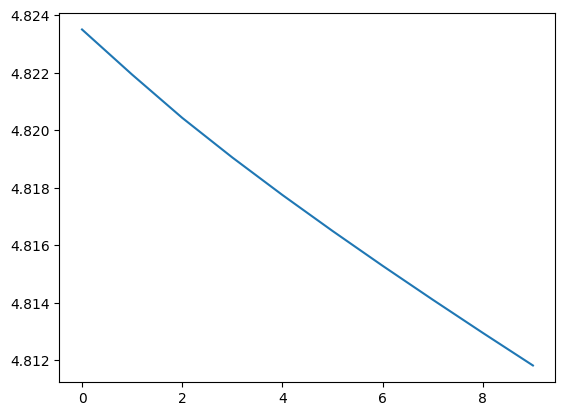

In [ ]:
plt.plot(discharge_capacities)

In [ ]:
def calulate_SoC(Q_vec, delta_t, const_i, t_cycle):
    Soc = 1 + (const_i * t_cycle)/(Q_vec[0]*36000)

    for i in range(1, len(Q_vec) - 2):
        Soc = Soc + (const_i * t_cycle)/(Q_vec[i-1]*36000)
        print(Soc)
    
    actual_SoC = Soc + (const_i * delta_t)/(Q_vec[-1]*36000)

    return actual_SoC

In [183]:
import pandas as pd

df = pd.read_csv("D:\Hackathon EESTech 2025\EESTEC-HACKATHON-2025\data 1\degradation.csv")


voltages_history = df["Voltage"]
voltages = []
for voltage_h in voltages_history[:1]:
    voltage_h_no_chars = voltage_h.replace("[", "")
    voltage_h_no_chars = voltage_h_no_chars.replace("]", "")
    voltage = np.array([float(v.strip()) for v in voltage_h_no_chars.split()])
    voltages.append(voltage)


In [187]:
avg_cycle_time = 0
for serie in voltages:
    avg_cycle_time += len(serie)

avg_cycle_time = avg_cycle_time / len(voltages)

avg_cycle_time

254.0

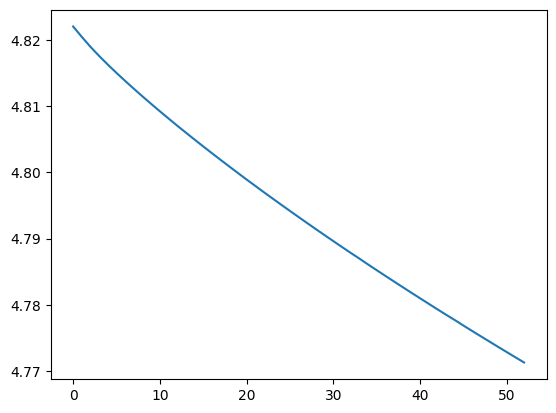

In [188]:
plt.plot(df["discharge_capacities"], label="Discharge capacity")

In [ ]:
Q_vec = df["discharge_capacities"].to_list()
my_SoC = calulate_SoC(Q_vec, 100000, -1, avg_cycle_time)
my_SoC0 = calulate_SoC(Q_vec, 0, -1, avg_cycle_time)

0.9970736335818826
0.9956099729368648
0.9941458546007188
0.9926813169895944
0.9912163826357322
0.9897510670439597
0.9882853822789269
0.9868193377446414
0.9853529411224909
0.9838861989548492
0.9824191182605646
0.9809517038451347
0.9794839597886299
0.9780158932851419
0.9765475066879007
0.9750788039536722
0.9736097893364712
0.9721404661275266
0.9706708368040697
0.9692009047646982
0.9677306713475279
0.9662601433575542
0.9647893194931098
0.9633182058361154
0.9618468032164382
0.9603751140638662
0.9589031414035875
0.9574308849689878
0.9559583483825583
0.9544855343991285
0.9530124444520736
0.9515390803798826
0.9500654446618103
0.9485915434492158
0.9471173689610103
0.9456429278441284
0.9441682211630085
0.9426932515991007
0.9412180202848623
0.9397425279034303
0.9382667773892309
0.9367907690986935
0.9353145049152238
0.9338379859301902
0.9323612206878752
0.9308841971066734
0.9294069219060352
0.9279293973580733
0.9264516251948454
0.9249736051583817
0.9970736335818826
0.9956099729368648
0.9941458546

In [213]:
my_SoC, my_SoC0

(0.3427873928616908, 0.9249736051583817)